<a href="https://colab.research.google.com/github/BrunoRBorges/Challenge_Data_Science/blob/main/Challenge_data_science_s02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Importa o Google Drive para o notebook
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Instala o PySpark na máquina virtual
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 38 kB/s 
     |████████████████████████████████| 199 kB 65.7 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=1f77f77bb970554f7268a1e668ce1e4e285a398d007d29ed0b454e0eb50ac027
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [3]:
# Importa a sessão Spark e os SparkTypes
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, DoubleType

In [4]:
# Cria a sessão Spark (lembrar de fechar a sessão depois)
spark = SparkSession.builder \
    .master('local[*]') \
    .appName("Challenge Semana 02") \
    .getOrCreate()

In [5]:
#Lê o arquivo Parquet e salva num dataset Spark
dataset_imoveis = spark.read.parquet('/content/drive/MyDrive/Challenge Data Science/Semana 2/part-00000-00341ba7-0a7c-4fef-a81e-1066725a64b1-c000.snappy.parquet')

In [6]:
#Coluna provisória, leitura de dados

dataset_imoveis.printSchema()
dataset_imoveis.show(5)

root
 |-- id: string (nullable = true)
 |-- andar: long (nullable = true)
 |-- area_total: string (nullable = true)
 |-- area_util: string (nullable = true)
 |-- banheiros: long (nullable = true)
 |-- caracteristicas: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- quartos: long (nullable = true)
 |-- suites: long (nullable = true)
 |-- tipo_anuncio: string (nullable = true)
 |-- tipo_unidade: string (nullable = true)
 |-- tipo_uso: string (nullable = true)
 |-- vaga: long (nullable = true)
 |-- bairro: string (nullable = true)
 |-- zona: string (nullable = true)
 |-- condominio: string (nullable = true)
 |-- iptu: string (nullable = true)
 |-- tipo: string (nullable = true)
 |-- valor: string (nullable = true)

+--------------------+-----+----------+---------+---------+--------------------+-------+------+------------+------------+-----------+----+------------+------------+----------+----+-----+------+
|                  id|andar|area_total|area_util|banhei

In [7]:
# Transforma as colunas com unidades diferenciadas em suas unidades corretas
dataset_imoveis = dataset_imoveis\
  .withColumn('andar',dataset_imoveis['andar'].cast(IntegerType()))\
  .withColumn('banheiros',dataset_imoveis['banheiros'].cast(IntegerType()))\
  .withColumn('quartos',dataset_imoveis['quartos'].cast(IntegerType()))\
  .withColumn('suites',dataset_imoveis['suites'].cast(IntegerType()))\
  .withColumn('vaga',dataset_imoveis['vaga'].cast(IntegerType()))\
  .withColumn('area_total',dataset_imoveis['area_total'].cast(DoubleType()))\
  .withColumn('area_util',dataset_imoveis['area_util'].cast(DoubleType()))\
  .withColumn('condominio',dataset_imoveis['condominio'].cast(DoubleType()))\
  .withColumn('iptu',dataset_imoveis['iptu'].cast(DoubleType()))\
  .withColumn('valor',dataset_imoveis['valor'].cast(DoubleType()))

In [8]:
#Coluna provisória, leitura de dados

dataset_imoveis.printSchema()
dataset_imoveis.show(5)

root
 |-- id: string (nullable = true)
 |-- andar: integer (nullable = true)
 |-- area_total: double (nullable = true)
 |-- area_util: double (nullable = true)
 |-- banheiros: integer (nullable = true)
 |-- caracteristicas: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- quartos: integer (nullable = true)
 |-- suites: integer (nullable = true)
 |-- tipo_anuncio: string (nullable = true)
 |-- tipo_unidade: string (nullable = true)
 |-- tipo_uso: string (nullable = true)
 |-- vaga: integer (nullable = true)
 |-- bairro: string (nullable = true)
 |-- zona: string (nullable = true)
 |-- condominio: double (nullable = true)
 |-- iptu: double (nullable = true)
 |-- tipo: string (nullable = true)
 |-- valor: double (nullable = true)

+--------------------+-----+----------+---------+---------+--------------------+-------+------+------------+------------+-----------+----+------------+------------+----------+------+-----+--------+
|                  id|andar|area_tot

In [9]:
#Início do tratamento de dados faltantes, importando a biblioteca functions para isso
from pyspark.sql import functions as f
from pyspark.sql.functions import explode

In [10]:
# checa valores nulos no dataset, excluindo a coluna caracteristicas
dataset_imoveis2 = dataset_imoveis.drop('caracteristicas')

# Conta quantos valores nulos há em cada coluna
dataset_imoveis2\
    .select([f.count(f.when(f.isnan(c) | f.isnull(c), True)).alias(c) for c in dataset_imoveis2.columns])\
    .show()

+---+-----+----------+---------+---------+-------+------+------------+------------+--------+----+------+----+----------+----+----+-----+
| id|andar|area_total|area_util|banheiros|quartos|suites|tipo_anuncio|tipo_unidade|tipo_uso|vaga|bairro|zona|condominio|iptu|tipo|valor|
+---+-----+----------+---------+---------+-------+------+------------+------------+--------+----+------+----+----------+----+----+-----+
|  0|    0|      9194|        0|        0|      0|  5554|           0|           0|       0|3017|     0|   0|      2371|7199|   0|    0|
+---+-----+----------+---------+---------+-------+------+------------+------------+--------+----+------+----+----------+----+----+-----+



In [11]:
# Nessa primeira linha, quando o tamanho do array for igual a zero (array vazio), ele irá susbtituir por valor nulo
dataset_imoveis = dataset_imoveis.withColumn('caracteristicas', f.when((f.size(f.col('caracteristicas')) == 0), f.lit(None)).otherwise(f.col('caracteristicas')))


In [12]:
# Aqui, eu concateno as caracteristicas todas numa única String, baseado no raciocínio anterior, quando a coluna for diferente de null, concatene seus elementos
dataset_imoveis = dataset_imoveis.withColumn('caracteristicas', f.when((f.isnull(f.col('caracteristicas')) == False),f.concat_ws(',',f.col('caracteristicas'))))


In [13]:
# Substitui os valores nulos por 0
dataset_imoveis = dataset_imoveis\
    .select('*')\
    .na\
    .fill(0)

In [14]:
#Coluna provisória, leitura de dados

dataset_imoveis.printSchema()
dataset_imoveis.show(5)

root
 |-- id: string (nullable = true)
 |-- andar: integer (nullable = true)
 |-- area_total: double (nullable = false)
 |-- area_util: double (nullable = false)
 |-- banheiros: integer (nullable = true)
 |-- caracteristicas: string (nullable = true)
 |-- quartos: integer (nullable = true)
 |-- suites: integer (nullable = true)
 |-- tipo_anuncio: string (nullable = true)
 |-- tipo_unidade: string (nullable = true)
 |-- tipo_uso: string (nullable = true)
 |-- vaga: integer (nullable = true)
 |-- bairro: string (nullable = true)
 |-- zona: string (nullable = true)
 |-- condominio: double (nullable = false)
 |-- iptu: double (nullable = false)
 |-- tipo: string (nullable = true)
 |-- valor: double (nullable = false)

+--------------------+-----+----------+---------+---------+--------------------+-------+------+------------+------------+-----------+----+------------+------------+----------+------+-----+--------+
|                  id|andar|area_total|area_util|banheiros|     caracteristica

In [15]:
# Aqui, para tirar o valor null de caracteristicas, o substituo pela string 'vazio'
dataset_imoveis = dataset_imoveis.withColumn('caracteristicas', f.when((f.isnull(f.col('caracteristicas')) == True),f.lit('vazio')).otherwise(f.col('caracteristicas')))                      
dataset_imoveis.show(5)

+--------------------+-----+----------+---------+---------+--------------------+-------+------+------------+------------+-----------+----+------------+------------+----------+------+-----+--------+
|                  id|andar|area_total|area_util|banheiros|     caracteristicas|quartos|suites|tipo_anuncio|tipo_unidade|   tipo_uso|vaga|      bairro|        zona|condominio|  iptu| tipo|   valor|
+--------------------+-----+----------+---------+---------+--------------------+-------+------+------------+------------+-----------+----+------------+------------+----------+------+-----+--------+
|03a386b6-7ab8-4ef...|    0|      43.0|     43.0|        1|Churrasqueira,Aca...|      2|     0|       Usado| Apartamento|Residencial|   1|    Realengo|  Zona Oeste|     285.0|   0.0|Venda| 22999.0|
|1fe78d41-b8e0-4d2...|    0|      44.0|     44.0|        1|               vazio|      2|     0|       Usado| Apartamento|Residencial|   0|       Irajá|  Zona Norte|     170.0|   0.0|Venda|110000.0|
|1fa1c1e5-

In [16]:
# checa valores nulos no dataset
dataset_imoveis\
    .select([f.count(f.when(f.isnan(c) | f.isnull(c), True)).alias(c) for c in dataset_imoveis.columns])\
    .show()

+---+-----+----------+---------+---------+---------------+-------+------+------------+------------+--------+----+------+----+----------+----+----+-----+
| id|andar|area_total|area_util|banheiros|caracteristicas|quartos|suites|tipo_anuncio|tipo_unidade|tipo_uso|vaga|bairro|zona|condominio|iptu|tipo|valor|
+---+-----+----------+---------+---------+---------------+-------+------+------------+------------+--------+----+------+----+----------+----+----+-----+
|  0|    0|         0|        0|        0|              0|      0|     0|           0|           0|       0|   0|     0|   0|         0|   0|   0|    0|
+---+-----+----------+---------+---------+---------------+-------+------+------------+------------+--------+----+------+----+----------+----+----+-----+



In [17]:
# Criando um Array único com todas as características
dataset_imoveis = dataset_imoveis.withColumn('caracteristicas_array',f.split(f.col('caracteristicas'),',').alias('caracteristicas_array'))
resultado = dataset_imoveis.select(dataset_imoveis['caracteristicas_array'],f.explode(dataset_imoveis.caracteristicas_array).alias('teste'))
resultado = resultado.select(resultado.teste)
lista_caracteristicas = resultado.distinct().rdd.flatMap(lambda x: x).collect()
lista_caracteristicas

['Condomínio fechado',
 'Playground',
 'Portão eletrônico',
 'Piscina',
 'Animais permitidos',
 'Portaria 24h',
 'vazio',
 'Elevador',
 'Academia',
 'Salão de festas',
 'Churrasqueira']

In [18]:
# Cria as colunas Dummy baseadas nas características
caracteristicas_colunas = [f.when(f.col('caracteristicas').contains(caracteristica), 1).otherwise(0).alias(caracteristica) for caracteristica in lista_caracteristicas]
dataset_imoveis_dummy1 = dataset_imoveis.select('*',*caracteristicas_colunas)
dataset_imoveis_dummy1 = dataset_imoveis_dummy1.drop('caracteristicas','caracteristicas_array')
dataset_imoveis_dummy1.show(5)

+--------------------+-----+----------+---------+---------+-------+------+------------+------------+-----------+----+------------+------------+----------+------+-----+--------+------------------+----------+-----------------+-------+------------------+------------+-----+--------+--------+---------------+-------------+
|                  id|andar|area_total|area_util|banheiros|quartos|suites|tipo_anuncio|tipo_unidade|   tipo_uso|vaga|      bairro|        zona|condominio|  iptu| tipo|   valor|Condomínio fechado|Playground|Portão eletrônico|Piscina|Animais permitidos|Portaria 24h|vazio|Elevador|Academia|Salão de festas|Churrasqueira|
+--------------------+-----+----------+---------+---------+-------+------+------------+------------+-----------+----+------------+------------+----------+------+-----+--------+------------------+----------+-----------------+-------+------------------+------------+-----+--------+--------+---------------+-------------+
|03a386b6-7ab8-4ef...|    0|      43.0|    

In [19]:
# Criando um Array único com todas as zonas
lista_zonas = dataset_imoveis_dummy1.select(dataset_imoveis_dummy1.zona).distinct().rdd.flatMap(lambda x: x).collect()
lista_zonas.remove('')

In [20]:
# Cria as colunas Dummy baseadas nas zonas
zonas_colunas = [f.when(f.col('zona').contains(zona), 1).otherwise(0).alias(zona) for zona in lista_zonas]
dataset_imoveis_dummy2 = dataset_imoveis_dummy1.select('*',*zonas_colunas)
dataset_imoveis_dummy2 = dataset_imoveis_dummy2.drop('zona','area_total')
dataset_imoveis_dummy2.show(5)

+--------------------+-----+---------+---------+-------+------+------------+------------+-----------+----+------------+----------+------+-----+--------+------------------+----------+-----------------+-------+------------------+------------+-----+--------+--------+---------------+-------------+----------+----------+------------+--------+
|                  id|andar|area_util|banheiros|quartos|suites|tipo_anuncio|tipo_unidade|   tipo_uso|vaga|      bairro|condominio|  iptu| tipo|   valor|Condomínio fechado|Playground|Portão eletrônico|Piscina|Animais permitidos|Portaria 24h|vazio|Elevador|Academia|Salão de festas|Churrasqueira|Zona Norte|Zona Oeste|Zona Central|Zona Sul|
+--------------------+-----+---------+---------+-------+------+------------+------------+-----------+----+------------+----------+------+-----+--------+------------------+----------+-----------------+-------+------------------+------------+-----+--------+--------+---------------+-------------+----------+----------+------

In [21]:
# Cria o output num arquivo Parquet
dataset_imoveis_dummy2.write.parquet(
    path = '/content/drive/MyDrive/Challenge Data Science/Semana 2/output_parquet_dataframe',
    mode = 'overwrite',
)

In [22]:
# Iniciando a etapa de Machine Learning

from pyspark.ml.stat import Correlation
import pandas as pd
from pyspark.ml.feature import VectorAssembler

In [23]:
# Renomeando as colunas para a vetorização

dataset_imoveis_dummy2 = dataset_imoveis_dummy2.withColumnRenamed('valor','label')


In [24]:
# Criando a lista de variáveis de input X
X = ['andar','area_util','banheiros','quartos','suites','vaga','condominio','iptu'] + lista_caracteristicas + lista_zonas
X

['andar',
 'area_util',
 'banheiros',
 'quartos',
 'suites',
 'vaga',
 'condominio',
 'iptu',
 'Condomínio fechado',
 'Playground',
 'Portão eletrônico',
 'Piscina',
 'Animais permitidos',
 'Portaria 24h',
 'vazio',
 'Elevador',
 'Academia',
 'Salão de festas',
 'Churrasqueira',
 'Zona Norte',
 'Zona Oeste',
 'Zona Central',
 'Zona Sul']

In [25]:
# Criando o Assemble de vetorização

assembler = VectorAssembler(inputCols = X, outputCol = 'features')

In [27]:
# Vetorizando o Dataframe

dataset_imoveis_vetorizado = assembler.transform(dataset_imoveis_dummy2).select('features', 'label')
dataset_imoveis_vetorizado.show(5)

+--------------------+--------+
|            features|   label|
+--------------------+--------+
|(23,[1,2,3,5,6,8,...| 22999.0|
|(23,[1,2,3,6,14,1...|110000.0|
|(23,[0,1,2,3,5,14...|115000.0|
|(23,[0,1,2,3,14,1...|115000.0|
|(23,[1,2,3,6,7,14...|125000.0|
+--------------------+--------+
only showing top 5 rows



In [54]:
# Importando as bibliotecas de matplotlib e seaborn
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
# Importando a biblioteca de regressão linear

from pyspark.ml.regression import LinearRegression

In [42]:
# Criando a regressão Linear, separando o dataframe em dois grupos

grupo_treino, grupo_teste = dataset_imoveis_vetorizado.randomSplit([0.7,0.3], seed = 101)
print("O grupo de treino possui ", grupo_treino.count(), "dados, já o grupo de teste possui ", grupo_teste.count(), " dados.")

O grupo de treino possui  46510 dados, já o grupo de teste possui  20052  dados.


In [44]:
# Instanciando a regressão linear

lr = LinearRegression()
modelo_lr = lr.fit(grupo_treino)
previsoes_lr_treino = modelo_lr.transform(grupo_treino)
previsoes_lr_treino.show(5)

+--------------------+---------+------------------+
|            features|    label|        prediction|
+--------------------+---------+------------------+
|(23,[0,1,2,3,4,5,...|1415000.0|1689007.0916487856|
|(23,[0,1,2,3,4,5,...| 230000.0| 274036.8850726607|
|(23,[0,1,2,3,4,5,...| 459000.0| 803041.4540375648|
|(23,[0,1,2,3,4,5,...| 520000.0| 803041.4540375648|
|(23,[0,1,2,3,4,5,...| 349999.0| 597621.4679384611|
+--------------------+---------+------------------+
only showing top 5 rows



In [50]:
# Cria o resumo da qualidade da regressão linear
# O R2 se refere a quanto o modelo está ajustado aos dados, isto é, quanto ele reflete a realidade dos dados
# o RMSE que é o erro médio elevado ao quadrado e depois calculamos a raiz de tudo para verificarmos uma métrica que avalia os erros do modelo e não o modelo em si

resumo_lr = modelo_lr.summary
print("A regressão linear representa em ", round(resumo_lr.r2*100,2),"% os resultados da base de treino, com um erro RMSE de R$", round(resumo_lr.rootMeanSquaredError,2))


A regressão linear representa em  68.89 % os resultados da base de treino, com um erro RMSE de R$ 825112.99


In [51]:
# Avalia o modelo de Linear Regression aplicado aos dados de teste

resumo_teste_lr = modelo_lr.evaluate(grupo_teste)
print("A regressão linear representa em ", round(resumo_teste_lr.r2*100,2),"% os resultados da base de testes, com um erro RMSE de R$", round(resumo_teste_lr.rootMeanSquaredError,2))

A regressão linear representa em  60.03 % os resultados da base de testes, com um erro RMSE de R$ 919150.43


Analisar a árvore de autocorrelação rende alguns dados super interessantes de interpretar! Escrevo aqui em texto, afinal, quem estiver lendo pode analisar essas curiosidades também.

Por exemplo, a correlação mais alta de imóveis com piscina é com imóveis que possuem churrasqueira (0.8) e realmente, se eu tivesse uma piscina, com certeza também teria uma churrasqueira!

Enquanto isso, area_util tem alta correlação com quantidade de quartos, banheiros e suítes e vagas, mostrando, mais uma vez, a coerência dos dados.



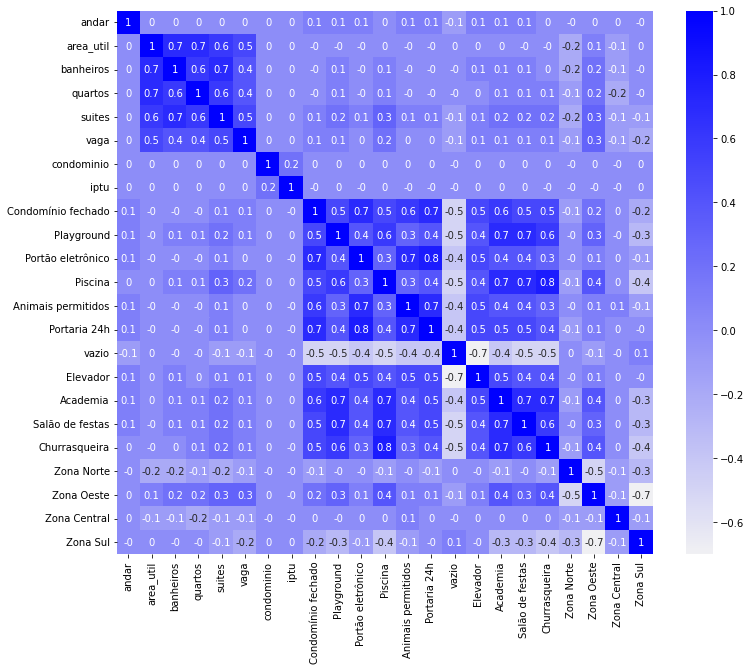

In [57]:
## DESAFIO EXTRA!!
# Análise do gráfico de autocorrelação
correlacao = Correlation.corr(dataset_imoveis_vetorizado,'features').collect()[0][0]
dataframe_correlacao = pd.DataFrame(correlacao.toArray(), columns=X, index=X)

print("Analisar a árvore de autocorrelação rende alguns dados super interessantes de interpretar! Escrevo aqui em texto, afinal, quem estiver lendo pode analisar essas curiosidades também.\n")
print("Por exemplo, a correlação mais alta de imóveis com piscina é com imóveis que possuem churrasqueira (0.8) e realmente, se eu tivesse uma piscina, com certeza também teria uma churrasqueira!\n")
print("Enquanto isso, area_util tem alta correlação com quantidade de quartos, banheiros e suítes e vagas, mostrando, mais uma vez, a coerência dos dados.\n")
plt.figure(figsize=(12,10))
paleta = sns.color_palette("light:blue", as_cmap=True)
sns.heatmap(dataframe_correlacao.round(1), annot=True, cmap=paleta)

In [58]:
## DESAFIO EXTRA!!
# Redução de dimensionalidade dos hiperparametros
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol='features', outputCol='scaled_features')
scaler_model = scaler.fit(dataset_imoveis_vetorizado)
dados_imoveis_scaled = scaler_model.transform(dataset_imoveis_vetorizado)

In [59]:
# Aplicando o método PCA
from pyspark.ml.feature import PCA

#Possuímos 23 hiperparametros, inicialmente vou manter o número, para poder analisar com calma para quantos vale a pena reduzir
pca = PCA(k=23, inputCol='scaled_features', outputCol='pca_features')
model_pca = pca.fit(dados_imoveis_scaled)
dados_imoveis_pca = model_pca.transform(dados_imoveis_scaled)

In [61]:
# Análise dos hiperparametros
lista_valores_pca = [sum(model_pca.explainedVariance[0:i+1]) for i in range(23)]
lista_valores_pca

[0.28290318876142934,
 0.43305780285695916,
 0.520289859924062,
 0.5748009457451903,
 0.6270312617154071,
 0.6736316737963346,
 0.717430788894111,
 0.758999938209562,
 0.7936936424113791,
 0.8267949210962381,
 0.853985042178437,
 0.8738389887177939,
 0.8924106786165669,
 0.9087960760383412,
 0.923614938780153,
 0.9373285702573324,
 0.9503571832164902,
 0.9616824586414028,
 0.9726952943001502,
 0.9826896337783936,
 0.9915865969885213,
 0.9999885446165532,
 0.9999999999999997]

In [62]:
# Resultado PCA
print("Analisando os dados resultantes do PCA, imaginando um objetivo de ao menos 90% de explicação dos dados, precisaríamos de 13 hiperparametros, é uma redução de 10 hiperparametros, mas ainda é bastante.\n")
print("Para uma precisão de 80%, seriam precisos 10 hiperparametros, enquanto que para 70% 7.\n")

Analisando os dados resultantes do PCA, imaginando um objetivo de ao menos 90% de explicação dos dados, precisaríamos de 13 hiperparametros, é uma redução de 10 hiperparametros, mas ainda é bastante.

Para uma precisão de 80%, seriam precisos 10 hiperparametros, enquanto que para 70% 7.



In [67]:
# Refazendo o PCA com 10 hiperparametros, para atingir 80% de explicação dos dados
pca = PCA(k=10, inputCol='scaled_features', outputCol='pca_features')
model_pca = pca.fit(dados_imoveis_scaled)
dados_imoveis_pca = model_pca.transform(dados_imoveis_scaled)

In [68]:
# Criando a regressão Linear dos dados PCA
# Renomeando as colunas dos dados PCA para poder separar os grupos
dados_imoveis_pca_renomeado = dados_imoveis_pca.drop('features','scaled_features')
dados_imoveis_pca_renomeado = dados_imoveis_pca_renomeado.withColumnRenamed('pca_features','features')
dados_imoveis_pca_renomeado = dados_imoveis_pca_renomeado.select('features','label')
dados_imoveis_pca_renomeado.show(5)

+--------------------+--------+
|            features|   label|
+--------------------+--------+
|[-5.2690837653545...| 22999.0|
|[0.61568239138357...|110000.0|
|[0.05346370593949...|115000.0|
|[0.60555529969209...|115000.0|
|[0.48456680564758...|125000.0|
+--------------------+--------+
only showing top 5 rows



In [69]:
# Separando os grupos e testando a regressão linear
grupo_treino_pca, grupo_teste_pca = dados_imoveis_pca_renomeado.randomSplit([0.7,0.3], seed = 101)
print("O grupo de treino possui ", grupo_treino.count(), "dados, já o grupo de teste possui ", grupo_teste.count(), " dados.")

modelo_lr_pca = lr.fit(grupo_treino_pca)
previsoes_lr_treino_pca = modelo_lr_pca.transform(grupo_treino_pca)

resumo_lr_pca = modelo_lr_pca.summary
print("A regressão linear representa em ", round(resumo_lr_pca.r2*100,2),"% os resultados da base de treino, com um erro RMSE de R$", round(resumo_lr_pca.rootMeanSquaredError,2))
resumo_teste_lr_pca = modelo_lr_pca.evaluate(grupo_teste_pca)
print("A regressão linear representa em ", round(resumo_teste_lr.r2*100,2),"% os resultados da base de testes, com um erro RMSE de R$", round(resumo_teste_lr.rootMeanSquaredError,2))

O grupo de treino possui  46510 dados, já o grupo de teste possui  20052  dados.
A regressão linear representa em  59.17 % os resultados da base de treino, com um erro RMSE de R$ 944426.59
A regressão linear representa em  60.03 % os resultados da base de testes, com um erro RMSE de R$ 919150.43


In [70]:
print("Os resultados não foram satisfatórios, pioraram em relação ao dados completos, façamos uma nova tentativa, com 13 hiperparametros")

Os resultados não foram satisfatórios, pioraram em relação ao dados completos, façamos uma nova tentativa, com 13 hiperparametros


In [71]:
# Novo teste PCA com 13 hiperparametros
pca = PCA(k=13, inputCol='scaled_features', outputCol='pca_features')
model_pca = pca.fit(dados_imoveis_scaled)
dados_imoveis_pca = model_pca.transform(dados_imoveis_scaled)

dados_imoveis_pca_renomeado = dados_imoveis_pca.drop('features','scaled_features')
dados_imoveis_pca_renomeado = dados_imoveis_pca_renomeado.withColumnRenamed('pca_features','features')
dados_imoveis_pca_renomeado = dados_imoveis_pca_renomeado.select('features','label')

# Separando os grupos e testando a regressão linear
grupo_treino_pca, grupo_teste_pca = dados_imoveis_pca_renomeado.randomSplit([0.7,0.3], seed = 101)
print("O grupo de treino possui ", grupo_treino.count(), "dados, já o grupo de teste possui ", grupo_teste.count(), " dados.")

modelo_lr_pca = lr.fit(grupo_treino_pca)
previsoes_lr_treino_pca = modelo_lr_pca.transform(grupo_treino_pca)

resumo_lr_pca = modelo_lr_pca.summary
print("A regressão linear representa em ", round(resumo_lr_pca.r2*100,2),"% os resultados da base de treino, com um erro RMSE de R$", round(resumo_lr_pca.rootMeanSquaredError,2))
resumo_teste_lr_pca = modelo_lr_pca.evaluate(grupo_teste_pca)
print("A regressão linear representa em ", round(resumo_teste_lr.r2*100,2),"% os resultados da base de testes, com um erro RMSE de R$", round(resumo_teste_lr.rootMeanSquaredError,2))

O grupo de treino possui  46510 dados, já o grupo de teste possui  20052  dados.
A regressão linear representa em  59.61 % os resultados da base de treino, com um erro RMSE de R$ 939293.32
A regressão linear representa em  60.03 % os resultados da base de testes, com um erro RMSE de R$ 919150.43


In [72]:
print("A diferença acabou não sendo tão grande assim, é possível continuar trabalhando com apenas 10 hiperparametros.")

A diferença acabou não sendo tão grande assim, é possível continuar trabalhando com apenas 10 hiperparametros.


In [73]:
## DESAFIO EXTRA!!
# Utilizando o GBTRegressor com os dados de hiperparametros do PCA

from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

In [78]:
#GBTRegressor
gbtr = GBTRegressor(featuresCol='features', labelCol='label', maxIter=15)
gbtr = gbtr.fit(grupo_treino_pca)

#Aplicando o GBTRegressor
mdata = gbtr.transform(grupo_teste_pca)
 
rmse=RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse=rmse.evaluate(mdata) 
 
mae=RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")
mae=mae.evaluate(mdata) 
 
r2=RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
r2=r2.evaluate(mdata)

print("RMSE: ", rmse)
print("MAE: ", mae)
print("R-squared: ", r2)

RMSE:  829522.1754425816
MAE:  460034.34447996295
R-squared:  0.6758274774686297


In [79]:
print("Utilizando o GBTRegressor, conseguimos atingir uma acuracidade média de 67%, bem superior aos 60% da regressão linear.")

Utilizando o GBTRegressor, conseguimos atingir uma acuracidade média de 67%, bem superior aos 60% da regressão linear.


In [80]:
# Encerra a sessão Spark
spark.stop

<bound method SparkSession.stop of <pyspark.sql.session.SparkSession object at 0x7f44108c35e0>>